In [1]:
# Import necessary libraries
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import f1_score, roc_curve, auc, jaccard_score
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import torch.optim as optim
from sklearn.decomposition import PCA

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Define the dataset paths
DATASET_DIR = '/content/drive/MyDrive/wood_dataset/wood'

class WoodDataset(Dataset):
    def __init__(self, image_paths, transform=None, grayscale=True):
        self.image_paths = image_paths
        self.transform = transform
        self.grayscale = grayscale

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        if self.grayscale:
            img = Image.open(img_path).convert('L')
            # Convert to 3-channel for pretrained models if using transform
            if self.transform:
                img = self.transform(img)
                img = torch.cat([img, img, img], dim=0)
        else:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)

        return img, img_path

# Data transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# Helper function to load image paths
def get_image_paths(folder_path):
    return sorted(glob(os.path.join(folder_path, '*.jpg')))

# Get image paths
train_good_paths = get_image_paths(os.path.join(DATASET_DIR, 'train/good'))
test_good_paths = get_image_paths(os.path.join(DATASET_DIR, 'test/good'))
test_defect_paths = get_image_paths(os.path.join(DATASET_DIR, 'test/defect'))
mask_defect_paths = get_image_paths(os.path.join(DATASET_DIR, 'ground_truth/defect'))

# Create datasets
train_dataset = WoodDataset(train_good_paths, transform=transform, grayscale=True)
test_good_dataset = WoodDataset(test_good_paths, transform=transform, grayscale=True)
test_defect_dataset = WoodDataset(test_defect_paths, transform=transform, grayscale=True)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_good_loader = DataLoader(test_good_dataset, batch_size=16, shuffle=False)
test_defect_loader = DataLoader(test_defect_dataset, batch_size=16, shuffle=False)

# Print dataset sizes
print(f"Train samples: {len(train_dataset)}")
print(f"Test good samples: {len(test_good_dataset)}")
print(f"Test defect samples: {len(test_defect_dataset)}")

Train samples: 70
Test good samples: 70
Test defect samples: 71


In [5]:
class InspectEfficientNet(nn.Module):
    """Helper class to check the EfficientNet architecture dimensions"""
    def __init__(self):
        super(InspectEfficientNet, self).__init__()
        weights = EfficientNet_B0_Weights.DEFAULT
        self.backbone = efficientnet_b0(weights=weights)

    def forward(self, x):
        feature_dims = {}
        # Print all feature dimensions
        x_temp = x
        for idx, module in enumerate(self.backbone.features):
            x_temp = module(x_temp)
            feature_dims[f"feature_{idx}"] = x_temp.shape
        return feature_dims

# Inspect the model architecture
inspector = InspectEfficientNet()
with torch.no_grad():
    dummy_input = torch.randn(1, 3, 256, 256)
    feature_dims = inspector(dummy_input)
    print("EfficientNet-B0 feature dimensions:")
    for layer, shape in feature_dims.items():
        print(f"  {layer}: {shape}")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 110MB/s] 


EfficientNet-B0 feature dimensions:
  feature_0: torch.Size([1, 32, 128, 128])
  feature_1: torch.Size([1, 16, 128, 128])
  feature_2: torch.Size([1, 24, 64, 64])
  feature_3: torch.Size([1, 40, 32, 32])
  feature_4: torch.Size([1, 80, 16, 16])
  feature_5: torch.Size([1, 112, 16, 16])
  feature_6: torch.Size([1, 192, 8, 8])
  feature_7: torch.Size([1, 320, 8, 8])
  feature_8: torch.Size([1, 1280, 8, 8])


In [6]:
class EfficientADRevised(nn.Module):
    """EfficientAD with proper dimension handling"""
    def __init__(self, input_size=(256, 256)):
        super(EfficientADRevised, self).__init__()

        self.input_size = input_size

        # Load pretrained feature extractor and freeze it
        weights = EfficientNet_B0_Weights.DEFAULT
        self.backbone = efficientnet_b0(weights=weights)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.backbone.eval()

        # Detect actual dimensions from the model
        dummy_input = torch.randn(1, 3, *input_size)
        feature_dims = {}
        feature_shapes = {}
        with torch.no_grad():
            x_temp = dummy_input
            for idx, module in enumerate(self.backbone.features):
                x_temp = module(x_temp)
                feature_dims[idx] = x_temp.shape[1]  # Channel dimension
                feature_shapes[idx] = (x_temp.shape[2], x_temp.shape[3])  # Spatial dimensions

        print("EfficientNet-B0 feature dimensions and shapes:")
        for idx, dim in feature_dims.items():
            print(f"  Layer {idx}: {dim} channels, shape {feature_shapes[idx]}")

        # Set the early and mid layer indices based on inspection
        self.early_layer_idx = 1
        self.mid_layer_idx = 3

        print(f"Using early layer {self.early_layer_idx} ({feature_dims[self.early_layer_idx]} channels)")
        print(f"Using mid layer {self.mid_layer_idx} ({feature_dims[self.mid_layer_idx]} channels)")

        # Create projection layers with correct dimensions
        self.teacher_proj = nn.ModuleDict({
            'early': nn.Conv2d(feature_dims[self.early_layer_idx], 64, 1),
            'mid': nn.Conv2d(feature_dims[self.mid_layer_idx], 64, 1)
        })

        # Calculate student feature output sizes based on input size
        h, w = input_size
        # After first conv+bn+relu: stride 2
        h1, w1 = h // 2, w // 2  # 128x128 for 256x256 input
        # After second conv+bn+relu: stride 2
        h2, w2 = h1 // 2, w1 // 2  # 64x64
        # After third conv+bn+relu: stride 2
        h3, w3 = h2 // 2, w2 // 2  # 32x32
        # After fourth conv+bn+relu: stride 2
        h4, w4 = h3 // 2, w3 // 2  # 16x16

        # Record these sizes for later
        self.student_feature_sizes = {
            'level1': (h1, w1),
            'level2': (h2, w2),
            'level3': (h3, w3),
            'level4': (h4, w4)
        }

        print(f"Student feature sizes: {self.student_feature_sizes}")

        # Student model - simple CNN
        self.student = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # level1
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # level2
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # level3
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # level4
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # Projection layers for student
        self.student_proj = nn.ModuleDict({
            'early': nn.Conv2d(32, 64, 1),  # From level2
            'mid': nn.Conv2d(64, 64, 1),    # From level3
        })

        # Decoder with explicit output size control
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        # Log variance for uncertainty weighting
        self.log_variance = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        # Store the input shape
        input_shape = x.shape

        # Extract teacher features
        with torch.no_grad():
            # Extract features at specific layers
            features = {}
            x_teacher = x
            for idx, module in enumerate(self.backbone.features):
                x_teacher = module(x_teacher)
                if idx == self.early_layer_idx:  # Early features
                    features['early'] = self.teacher_proj['early'](x_teacher)
                elif idx == self.mid_layer_idx:  # Mid-level features
                    features['mid'] = self.teacher_proj['mid'](x_teacher)

        # Extract student features
        student_feats = {}
        x_student = x
        for idx, layer in enumerate(self.student):
            x_student = layer(x_student)
            if idx == 3:  # After second conv+bn+relu
                student_feats['early'] = self.student_proj['early'](x_student)
            elif idx == 7:  # After third conv+bn+relu
                student_feats['mid'] = self.student_proj['mid'](x_student)

        # Align spatial dimensions between teacher and student
        aligned_teacher_feats = {}
        for feat_name in ['early', 'mid']:
            # Use student size as target size
            target_size = student_feats[feat_name].shape[2:]
            # Resize teacher features to match student
            aligned_teacher_feats[feat_name] = F.interpolate(
                features[feat_name],
                size=target_size,
                mode='bilinear',
                align_corners=False
            )

        # Reconstruct from mid-level features
        recon = self.decoder(student_feats['mid'])

        # Ensure reconstruction matches input size
        if recon.shape[2:] != input_shape[2:]:
            print(f"Resizing reconstruction from {recon.shape[2:]} to {input_shape[2:]}")
            recon = F.interpolate(recon, size=input_shape[2:], mode='bilinear')

        # Return features and reconstruction
        results = {
            'teacher_features': aligned_teacher_feats,
            'student_features': student_feats,
            'reconstruction': recon
        }

        return results

    def compute_anomaly_score(self, x):
        """Compute anomaly score for an input batch"""
        outputs = self(x)

        # Calculate feature discrepancy
        disc_early = F.mse_loss(
            outputs['student_features']['early'],
            outputs['teacher_features']['early'],
            reduction='none'
        ).mean(dim=1)

        disc_mid = F.mse_loss(
            outputs['student_features']['mid'],
            outputs['teacher_features']['mid'],
            reduction='none'
        ).mean(dim=1)

        # Calculate reconstruction error
        recon_error = F.mse_loss(
            outputs['reconstruction'],
            x,
            reduction='none'
        ).mean(dim=1)

        # Resize all maps to input size
        input_size = (x.shape[2], x.shape[3])
        disc_early_resized = F.interpolate(disc_early.unsqueeze(1), size=input_size, mode='bilinear').squeeze(1)
        disc_mid_resized = F.interpolate(disc_mid.unsqueeze(1), size=input_size, mode='bilinear').squeeze(1)

        # Combine maps (weighted sum)
        anomaly_map = 0.3 * disc_early_resized + 0.4 * disc_mid_resized + 0.3 * recon_error

        # Image-level score (maximum value in the anomaly map)
        anomaly_score = anomaly_map.view(anomaly_map.size(0), -1).max(dim=1)[0]

        return {
            'anomaly_map': anomaly_map.cpu().numpy(),
            'anomaly_score': anomaly_score.cpu().numpy()
        }

In [7]:
def train_efficient_ad(model, train_loader, val_loader=None, epochs=10, lr=1e-4):
    """
    Train the EfficientAD model

    Args:
        model: EfficientAD model
        train_loader: DataLoader with normal training samples
        val_loader: Optional DataLoader for validation
        epochs: Number of training epochs
        lr: Learning rate

    Returns:
        Trained model and training history
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_distill_loss = 0
        train_recon_loss = 0

        for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
            data = data.to(device)
            optimizer.zero_grad()

            outputs = model(data)

            # Feature distillation loss
            distill_loss = F.mse_loss(
                outputs['student_features']['early'],
                outputs['teacher_features']['early']
            ) + F.mse_loss(
                outputs['student_features']['mid'],
                outputs['teacher_features']['mid']
            )

            # Reconstruction loss
            recon_loss = F.mse_loss(outputs['reconstruction'], data)

            # Total loss with uncertainty weighting
            precision = torch.exp(-model.log_variance)
            loss = precision * (distill_loss + recon_loss) + 0.5 * model.log_variance

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_distill_loss += distill_loss.item()
            train_recon_loss += recon_loss.item()

        train_loss /= len(train_loader)
        train_distill_loss /= len(train_loader)
        train_recon_loss /= len(train_loader)

        history['train_loss'].append(train_loss)

        if val_loader is not None:
            model.eval()
            val_loss = 0

            with torch.no_grad():
                for data, _ in val_loader:
                    data = data.to(device)
                    outputs = model(data)

                    # Feature distillation loss
                    distill_loss = F.mse_loss(
                        outputs['student_features']['early'],
                        outputs['teacher_features']['early']
                    ) + F.mse_loss(
                        outputs['student_features']['mid'],
                        outputs['teacher_features']['mid']
                    )

                    # Reconstruction loss
                    recon_loss = F.mse_loss(outputs['reconstruction'], data)

                    # Total loss with uncertainty weighting
                    precision = torch.exp(-model.log_variance)
                    loss = precision * (distill_loss + recon_loss) + 0.5 * model.log_variance

                    val_loss += loss.item()

            val_loss /= len(val_loader)
            history['val_loss'].append(val_loss)

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            print(f"  Distillation Loss: {train_distill_loss:.4f}, Reconstruction Loss: {train_recon_loss:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")
            print(f"  Distillation Loss: {train_distill_loss:.4f}, Reconstruction Loss: {train_recon_loss:.4f}")

        # Update learning rate
        scheduler.step()

    return model, history

Training on 63 samples, validating on 7 samples
EfficientNet-B0 feature dimensions and shapes:
  Layer 0: 32 channels, shape (128, 128)
  Layer 1: 16 channels, shape (128, 128)
  Layer 2: 24 channels, shape (64, 64)
  Layer 3: 40 channels, shape (32, 32)
  Layer 4: 80 channels, shape (16, 16)
  Layer 5: 112 channels, shape (16, 16)
  Layer 6: 192 channels, shape (8, 8)
  Layer 7: 320 channels, shape (8, 8)
  Layer 8: 1280 channels, shape (8, 8)
Using early layer 1 (16 channels)
Using mid layer 3 (40 channels)
Student feature sizes: {'level1': (128, 128), 'level2': (64, 64), 'level3': (32, 32), 'level4': (16, 16)}


Epoch 1/20:   0%|          | 0/4 [00:00<?, ?it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 1/20:  50%|█████     | 2/4 [00:15<00:15,  7.55s/it]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 1/20:  75%|███████▌  | 3/4 [00:21<00:06,  6.87s/it]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 1/20: 100%|██████████| 4/4 [00:32<00:00,  8.07s/it]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 1/20, Train Loss: 26.6649, Val Loss: 14.2085
  Distillation Loss: 25.7981, Reconstruction Loss: 0.8708


Epoch 2/20:  25%|██▌       | 1/4 [00:00<00:02,  1.33it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 2/20:  50%|█████     | 2/4 [00:01<00:01,  1.27it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 2/20:  75%|███████▌  | 3/4 [00:02<00:00,  1.27it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 2/20: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 2/20, Train Loss: 26.5818, Val Loss: 15.7425
  Distillation Loss: 25.7305, Reconstruction Loss: 0.8656


Epoch 3/20:  25%|██▌       | 1/4 [00:00<00:01,  1.81it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 3/20:  50%|█████     | 2/4 [00:01<00:01,  1.80it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 3/20:  75%|███████▌  | 3/4 [00:01<00:00,  1.79it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 3/20: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 3/20, Train Loss: 25.8223, Val Loss: 17.4686
  Distillation Loss: 24.9835, Reconstruction Loss: 0.8627


Epoch 4/20:  25%|██▌       | 1/4 [00:00<00:01,  1.81it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 4/20:  50%|█████     | 2/4 [00:01<00:01,  1.78it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 4/20:  75%|███████▌  | 3/4 [00:01<00:00,  1.81it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 4/20: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 4/20, Train Loss: 25.7798, Val Loss: 18.8739
  Distillation Loss: 24.9529, Reconstruction Loss: 0.8605


Epoch 5/20:  25%|██▌       | 1/4 [00:00<00:01,  1.84it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 5/20:  50%|█████     | 2/4 [00:01<00:01,  1.81it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 5/20:  75%|███████▌  | 3/4 [00:01<00:00,  1.82it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 5/20: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 5/20, Train Loss: 25.8893, Val Loss: 19.9807
  Distillation Loss: 25.0721, Reconstruction Loss: 0.8602


Epoch 6/20:  25%|██▌       | 1/4 [00:00<00:01,  1.79it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 6/20:  50%|█████     | 2/4 [00:01<00:01,  1.79it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 6/20:  75%|███████▌  | 3/4 [00:01<00:00,  1.79it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 6/20: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 6/20, Train Loss: 25.5137, Val Loss: 20.8327
  Distillation Loss: 24.7094, Reconstruction Loss: 0.8556


Epoch 7/20:  25%|██▌       | 1/4 [00:00<00:01,  1.61it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 7/20:  50%|█████     | 2/4 [00:01<00:01,  1.39it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 7/20:  75%|███████▌  | 3/4 [00:02<00:01,  1.08s/it]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 7/20: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 7/20, Train Loss: 25.5717, Val Loss: 21.5225
  Distillation Loss: 24.7765, Reconstruction Loss: 0.8549


Epoch 8/20:  25%|██▌       | 1/4 [00:01<00:03,  1.09s/it]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 8/20:  50%|█████     | 2/4 [00:01<00:01,  1.26it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 8/20:  75%|███████▌  | 3/4 [00:02<00:00,  1.47it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 8/20: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 8/20, Train Loss: 24.9866, Val Loss: 22.0435
  Distillation Loss: 24.2019, Reconstruction Loss: 0.8505


Epoch 9/20:  25%|██▌       | 1/4 [00:00<00:01,  1.82it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 9/20:  50%|█████     | 2/4 [00:01<00:01,  1.76it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 9/20:  75%|███████▌  | 3/4 [00:01<00:00,  1.78it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 9/20: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 9/20, Train Loss: 24.8038, Val Loss: 22.2296
  Distillation Loss: 24.0258, Reconstruction Loss: 0.8499


Epoch 10/20:  25%|██▌       | 1/4 [00:00<00:01,  1.75it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 10/20:  50%|█████     | 2/4 [00:01<00:01,  1.75it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 10/20:  75%|███████▌  | 3/4 [00:01<00:00,  1.77it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 10/20: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 10/20, Train Loss: 25.1193, Val Loss: 22.1414
  Distillation Loss: 24.3501, Reconstruction Loss: 0.8482


Epoch 11/20:  25%|██▌       | 1/4 [00:00<00:01,  1.82it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 11/20:  50%|█████     | 2/4 [00:01<00:01,  1.77it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 11/20:  75%|███████▌  | 3/4 [00:01<00:00,  1.61it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 11/20: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 11/20, Train Loss: 24.9598, Val Loss: 22.0138
  Distillation Loss: 24.1992, Reconstruction Loss: 0.8443


Epoch 12/20:  25%|██▌       | 1/4 [00:00<00:02,  1.28it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 12/20:  50%|█████     | 2/4 [00:01<00:01,  1.26it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 12/20:  75%|███████▌  | 3/4 [00:02<00:00,  1.45it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 12/20: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 12/20, Train Loss: 24.7174, Val Loss: 21.9987
  Distillation Loss: 23.9626, Reconstruction Loss: 0.8422


Epoch 13/20:  25%|██▌       | 1/4 [00:00<00:01,  1.77it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 13/20:  50%|█████     | 2/4 [00:01<00:01,  1.73it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 13/20:  75%|███████▌  | 3/4 [00:01<00:00,  1.74it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 13/20: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 13/20, Train Loss: 24.5952, Val Loss: 21.9649
  Distillation Loss: 23.8425, Reconstruction Loss: 0.8434


Epoch 14/20:  25%|██▌       | 1/4 [00:00<00:01,  1.86it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 14/20:  50%|█████     | 2/4 [00:01<00:01,  1.79it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 14/20:  75%|███████▌  | 3/4 [00:01<00:00,  1.81it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 14/20: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 14/20, Train Loss: 24.5607, Val Loss: 22.0351
  Distillation Loss: 23.8139, Reconstruction Loss: 0.8404


Epoch 15/20:  25%|██▌       | 1/4 [00:00<00:01,  1.79it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 15/20:  50%|█████     | 2/4 [00:01<00:01,  1.79it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 15/20:  75%|███████▌  | 3/4 [00:01<00:00,  1.79it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 15/20: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 15/20, Train Loss: 24.4166, Val Loss: 22.0811
  Distillation Loss: 23.6726, Reconstruction Loss: 0.8393


Epoch 16/20:  25%|██▌       | 1/4 [00:00<00:01,  1.79it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 16/20:  50%|█████     | 2/4 [00:01<00:01,  1.79it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 16/20:  75%|███████▌  | 3/4 [00:01<00:00,  1.70it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 16/20: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 16/20, Train Loss: 24.6914, Val Loss: 22.2035
  Distillation Loss: 23.9501, Reconstruction Loss: 0.8395


Epoch 17/20:  25%|██▌       | 1/4 [00:00<00:02,  1.25it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 17/20:  50%|█████     | 2/4 [00:01<00:01,  1.24it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 17/20:  75%|███████▌  | 3/4 [00:02<00:00,  1.37it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 17/20: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 17/20, Train Loss: 24.7535, Val Loss: 22.3426
  Distillation Loss: 24.0142, Reconstruction Loss: 0.8388


Epoch 18/20:  25%|██▌       | 1/4 [00:00<00:01,  1.83it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 18/20:  50%|█████     | 2/4 [00:01<00:01,  1.78it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 18/20:  75%|███████▌  | 3/4 [00:01<00:00,  1.80it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 18/20: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 18/20, Train Loss: 24.9556, Val Loss: 22.4535
  Distillation Loss: 24.2186, Reconstruction Loss: 0.8383


Epoch 19/20:  25%|██▌       | 1/4 [00:00<00:01,  1.82it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 19/20:  50%|█████     | 2/4 [00:01<00:01,  1.79it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 19/20:  75%|███████▌  | 3/4 [00:01<00:00,  1.79it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 19/20: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 19/20, Train Loss: 24.4701, Val Loss: 22.5220
  Distillation Loss: 23.7315, Reconstruction Loss: 0.8382


Epoch 20/20:  25%|██▌       | 1/4 [00:00<00:01,  1.81it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 20/20:  50%|█████     | 2/4 [00:01<00:01,  1.77it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 20/20:  75%|███████▌  | 3/4 [00:01<00:00,  1.77it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Epoch 20/20: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Epoch 20/20, Train Loss: 24.6077, Val Loss: 22.5789
  Distillation Loss: 23.8701, Reconstruction Loss: 0.8379


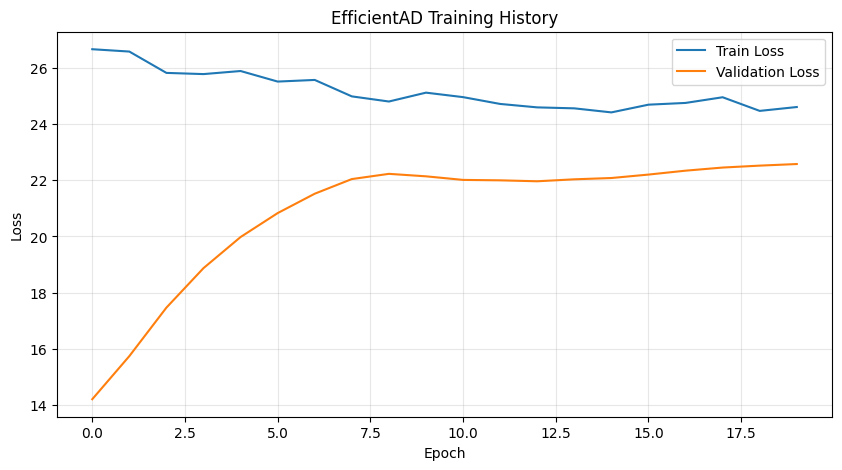

In [8]:
# Split training data into train and validation
from torch.utils.data import random_split

# Use 90% for training, 10% for validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_subset_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
val_subset_loader = DataLoader(val_subset, batch_size=16, shuffle=False)

print(f"Training on {train_size} samples, validating on {val_size} samples")

# Initialize the revised model
model = EfficientADRevised().to(device)

# Train the model (adjust epochs as needed)
model, history = train_efficient_ad(
    model=model,
    train_loader=train_subset_loader,
    val_loader=val_subset_loader,
    epochs=20,  # Use a smaller number for testing, increase for better results
    lr=1e-4
)

# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/wood_dataset/efficient_ad_final.pth')

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
if 'val_loss' in history and len(history['val_loss']) > 0:
    plt.plot(history['val_loss'], label='Validation Loss')
plt.title('EfficientAD Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [9]:
def evaluate_model(model, test_good_loader, test_defect_loader):
    """
    Evaluate model on test data

    Args:
        model: Trained EfficientAD model
        test_good_loader: DataLoader with normal test samples
        test_defect_loader: DataLoader with defect test samples

    Returns:
        Dictionary with results
    """
    model.eval()

    # Process normal samples
    print("Evaluating on normal test samples...")
    test_good_images = []
    test_good_paths = []
    test_good_scores = []
    test_good_maps = []

    with torch.no_grad():
        for batch, paths in tqdm(test_good_loader, desc="Processing normal samples"):
            batch = batch.to(device)
            test_good_images.extend(batch.cpu())
            test_good_paths.extend(paths)

            # Compute anomaly scores and maps
            results = model.compute_anomaly_score(batch)
            test_good_scores.extend(results['anomaly_score'])
            test_good_maps.extend(results['anomaly_map'])

    # Process defect samples
    print("Evaluating on defect test samples...")
    test_defect_images = []
    test_defect_paths = []
    test_defect_scores = []
    test_defect_maps = []

    with torch.no_grad():
        for batch, paths in tqdm(test_defect_loader, desc="Processing defect samples"):
            batch = batch.to(device)
            test_defect_images.extend(batch.cpu())
            test_defect_paths.extend(paths)

            # Compute anomaly scores and maps
            results = model.compute_anomaly_score(batch)
            test_defect_scores.extend(results['anomaly_score'])
            test_defect_maps.extend(results['anomaly_map'])

    # Combine all results
    all_images = test_good_images + test_defect_images
    all_paths = test_good_paths + test_defect_paths
    all_scores = np.concatenate([test_good_scores, test_defect_scores])
    all_maps = np.concatenate([test_good_maps, test_defect_maps])

    # Ground truth labels (0 for normal, 1 for anomaly)
    y_true = np.array([0] * len(test_good_scores) + [1] * len(test_defect_scores))

    # Calculate ROC curve and optimal threshold
    fpr, tpr, thresholds = roc_curve(y_true, all_scores)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Generate predictions based on the optimal threshold
    y_pred = (all_scores > optimal_threshold).astype(int)

    # Calculate F1 score and ROC AUC
    f1 = f1_score(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    print(f"Optimal threshold: {optimal_threshold:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    # Calculate scores statistics for good and defect samples
    print(f"Good samples - Mean score: {np.mean(test_good_scores):.4f}, Max: {np.max(test_good_scores):.4f}, Min: {np.min(test_good_scores):.4f}")
    print(f"Defect samples - Mean score: {np.mean(test_defect_scores):.4f}, Max: {np.max(test_defect_scores):.4f}, Min: {np.min(test_defect_scores):.4f}")

    return {
        "good": {
            "images": test_good_images,
            "paths": test_good_paths,
            "scores": test_good_scores,
            "maps": test_good_maps
        },
        "defect": {
            "images": test_defect_images,
            "paths": test_defect_paths,
            "scores": test_defect_scores,
            "maps": test_defect_maps
        },
        "all": {
            "images": all_images,
            "paths": all_paths,
            "scores": all_scores,
            "maps": all_maps
        },
        "metrics": {
            "y_true": y_true,
            "y_pred": y_pred,
            "f1": f1,
            "roc_auc": roc_auc,
            "optimal_threshold": optimal_threshold,
            "fpr": fpr,
            "tpr": tpr,
            "thresholds": thresholds
        }
    }

# Evaluate the model
evaluation_results = evaluate_model(model, test_good_loader, test_defect_loader)

# Extract key metrics
f1 = evaluation_results["metrics"]["f1"]
roc_auc = evaluation_results["metrics"]["roc_auc"]
optimal_threshold = evaluation_results["metrics"]["optimal_threshold"]

Evaluating on normal test samples...


Processing normal samples:  20%|██        | 1/5 [00:08<00:33,  8.36s/it]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Processing normal samples:  40%|████      | 2/5 [00:15<00:22,  7.48s/it]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Processing normal samples:  60%|██████    | 3/5 [00:22<00:15,  7.53s/it]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Processing normal samples:  80%|████████  | 4/5 [00:29<00:07,  7.08s/it]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Processing normal samples: 100%|██████████| 5/5 [00:31<00:00,  6.36s/it]


Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Evaluating on defect test samples...


Processing defect samples:  20%|██        | 1/5 [00:09<00:36,  9.13s/it]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Processing defect samples:  40%|████      | 2/5 [00:28<00:44, 14.94s/it]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Processing defect samples:  60%|██████    | 3/5 [00:41<00:28, 14.20s/it]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Processing defect samples:  80%|████████  | 4/5 [00:53<00:13, 13.20s/it]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


Processing defect samples: 100%|██████████| 5/5 [00:56<00:00, 11.34s/it]

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Optimal threshold: 51.0953
F1 Score: 0.6811
ROC AUC: 0.5594
Good samples - Mean score: 76.5402, Max: 309.3608, Min: 33.4794
Defect samples - Mean score: 88.0192, Max: 468.7210, Min: 43.2530


In [10]:
def plot_roc_curve(fpr, tpr, roc_auc):
    """Plot ROC curve with AUC."""
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

def plot_score_distributions(good_scores, defect_scores, threshold=None):
    """Plot distribution of anomaly scores for normal and anomalous samples."""
    plt.figure(figsize=(10, 6))
    plt.hist(good_scores, bins=30, alpha=0.5, label='Normal Samples', color='green')
    plt.hist(defect_scores, bins=30, alpha=0.5, label='Anomaly Samples', color='red')

    if threshold is not None:
        plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.4f}')

    plt.xlabel('Anomaly Score')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Anomaly Scores')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

def visualize_anomaly_detection(images, score_maps, scores, threshold, num_samples=5,
                                indices=None, cmap='jet'):
    """
    Visualize anomaly detection results with original image, heatmap, and overlay.

    Args:
        images: List of test images
        score_maps: Array of anomaly score maps
        scores: Array of anomaly scores
        threshold: Threshold for anomaly detection
        num_samples: Number of samples to visualize
        indices: Optional specific indices to visualize
        cmap: Colormap for heatmap visualization
    """
    if indices is None:
        indices = np.random.choice(len(images), size=min(num_samples, len(images)), replace=False)

    plt.figure(figsize=(15, 3*len(indices)))

    for i, idx in enumerate(indices):
        # Get the image
        img = images[idx].permute(1, 2, 0).cpu().numpy()
        # For grayscale (3 identical channels), take first channel
        if np.allclose(img[:,:,0], img[:,:,1]) and np.allclose(img[:,:,1], img[:,:,2]):
            img = img[:,:,0]

        # Denormalize the image for better visualization
        img = (img - img.min()) / (img.max() - img.min())

        # Get score map and normalize
        score_map = score_maps[idx]
        score_map_norm = (score_map - score_map.min()) / (score_map.max() - score_map.min() + 1e-7)

        # Binary mask using threshold
        binary_mask = (score_map_norm > threshold).astype(float)

        is_anomaly = scores[idx] > threshold

        # Plot original image
        plt.subplot(len(indices), 3, 3*i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{'Anomaly' if is_anomaly else 'Normal'} - Score: {scores[idx]:.4f}")
        plt.axis('off')

        # Plot heatmap
        plt.subplot(len(indices), 3, 3*i + 2)
        plt.imshow(score_map_norm, cmap=cmap)
        plt.title('Anomaly Heatmap')
        plt.axis('off')
        plt.colorbar(fraction=0.046, pad=0.04)

        # Plot overlay
        plt.subplot(len(indices), 3, 3*i + 3)
        plt.imshow(img, cmap='gray')
        plt.imshow(score_map_norm, cmap=cmap, alpha=0.5)
        plt.title('Anomaly Overlay')
        plt.axis('off')
        plt.colorbar(fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

def visualize_reconstructions(model, images, num_samples=3, indices=None):
    """
    Visualize original images alongside their reconstructions

    Args:
        model: EfficientAD model
        images: List of input images
        num_samples: Number of samples to visualize
        indices: Optional specific indices to visualize
    """
    if indices is None:
        indices = np.random.choice(len(images), size=min(num_samples, len(images)), replace=False)

    model.eval()
    plt.figure(figsize=(15, 4*len(indices)))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            # Get the image
            img = images[idx].unsqueeze(0).to(device)

            # Get model outputs (reconstructions)
            outputs = model(img)
            recon = outputs['reconstruction'][0].cpu()

            # Convert to numpy for visualization
            orig_img = images[idx].permute(1, 2, 0).cpu().numpy()
            if np.allclose(orig_img[:,:,0], orig_img[:,:,1]):
                orig_img = orig_img[:,:,0]

            recon_img = recon.permute(1, 2, 0).cpu().numpy()

            # Normalize for better visualization
            orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min() + 1e-7)
            recon_img = (recon_img - recon_img.min()) / (recon_img.max() - recon_img.min() + 1e-7)

            # Plot
            plt.subplot(len(indices), 2, 2*i + 1)
            plt.imshow(orig_img, cmap='gray')
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(len(indices), 2, 2*i + 2)
            plt.imshow(recon_img)
            plt.title('Reconstruction')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

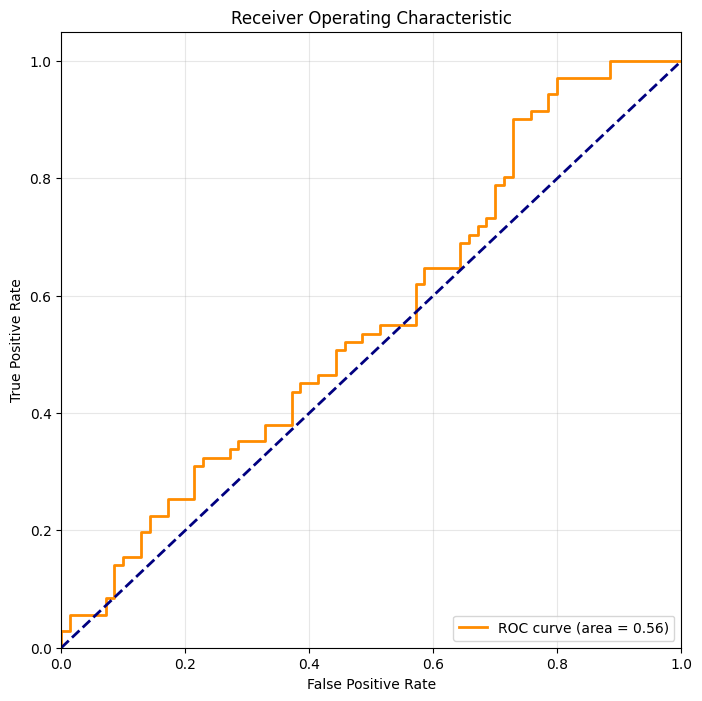

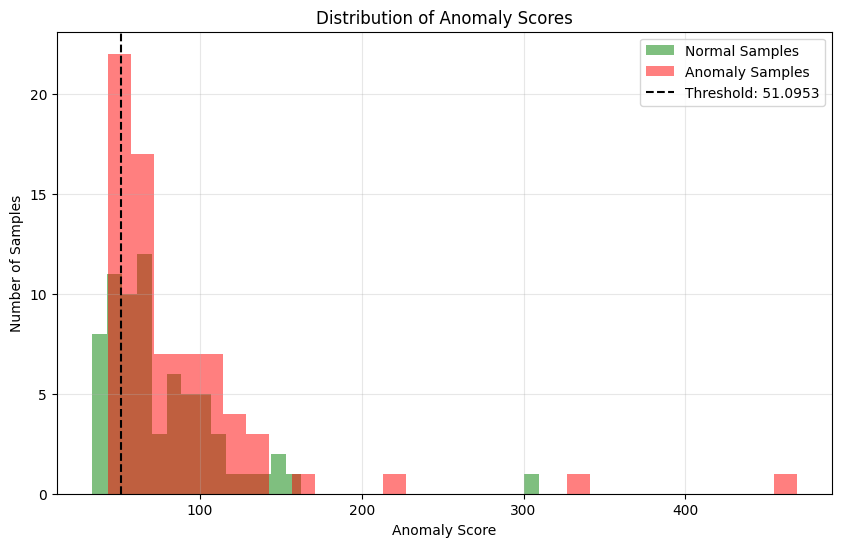

Normal samples visualization:


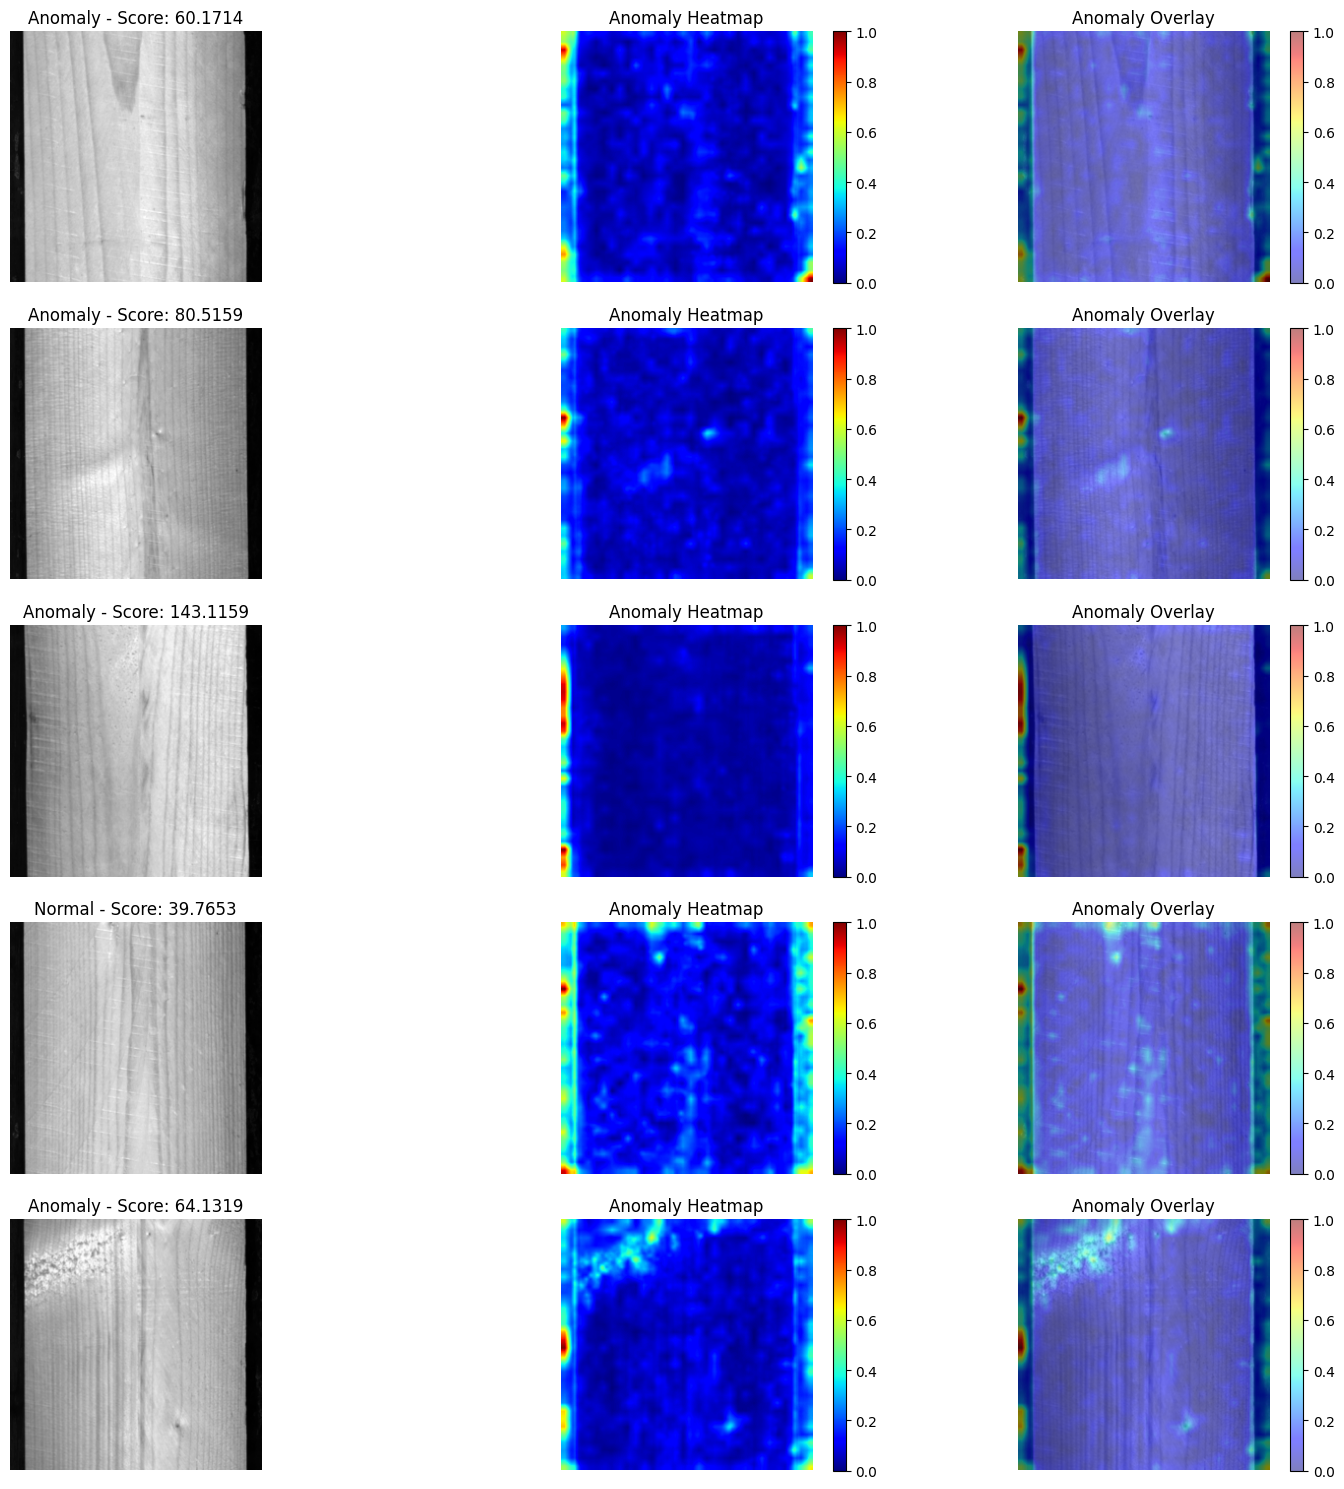

Anomaly samples visualization:


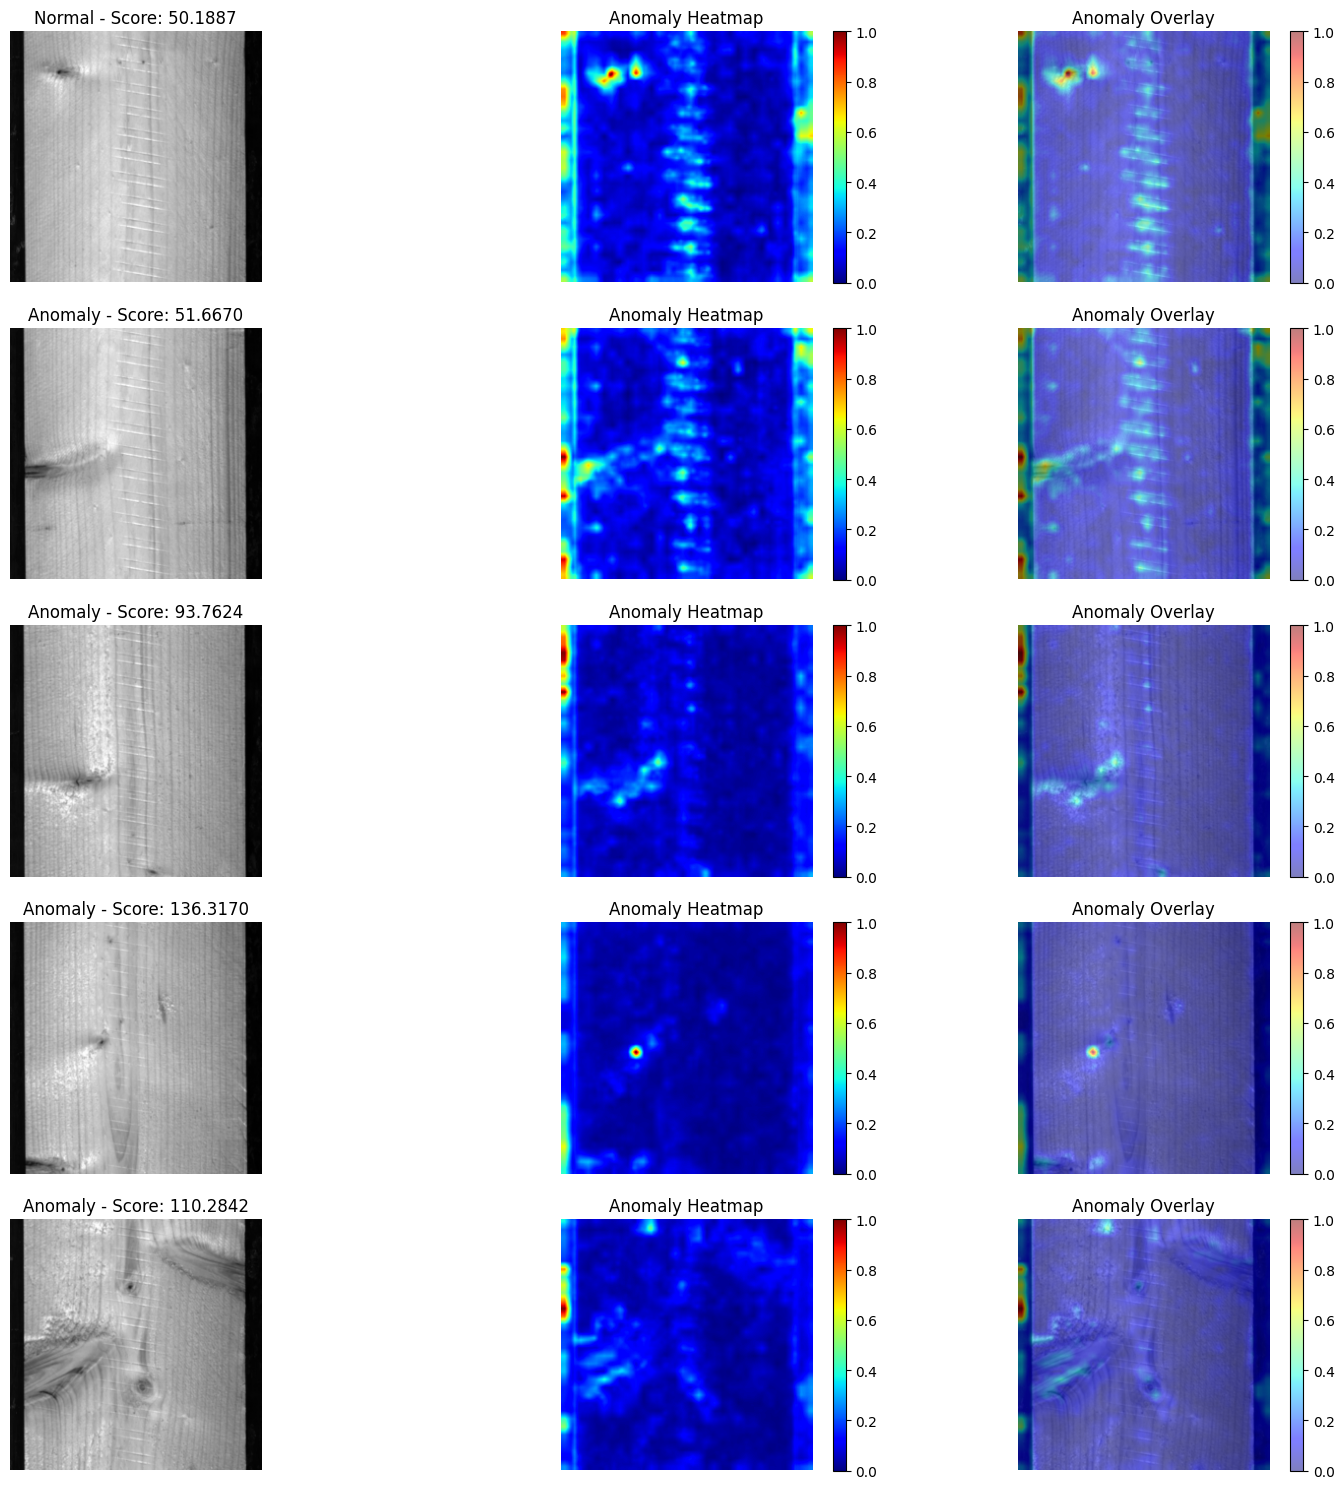

Reconstruction visualization:
Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


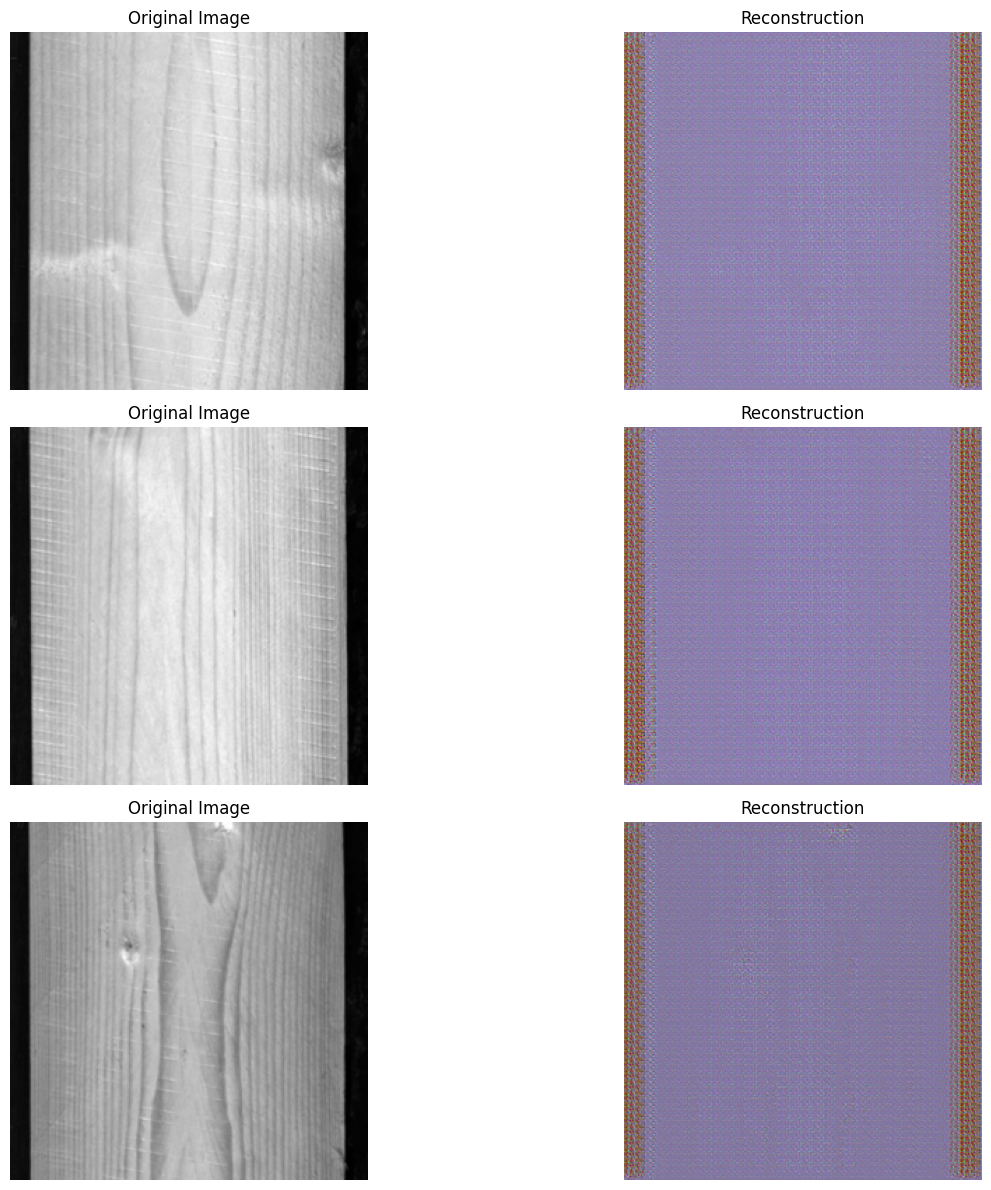

Defect reconstruction visualization:
Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])


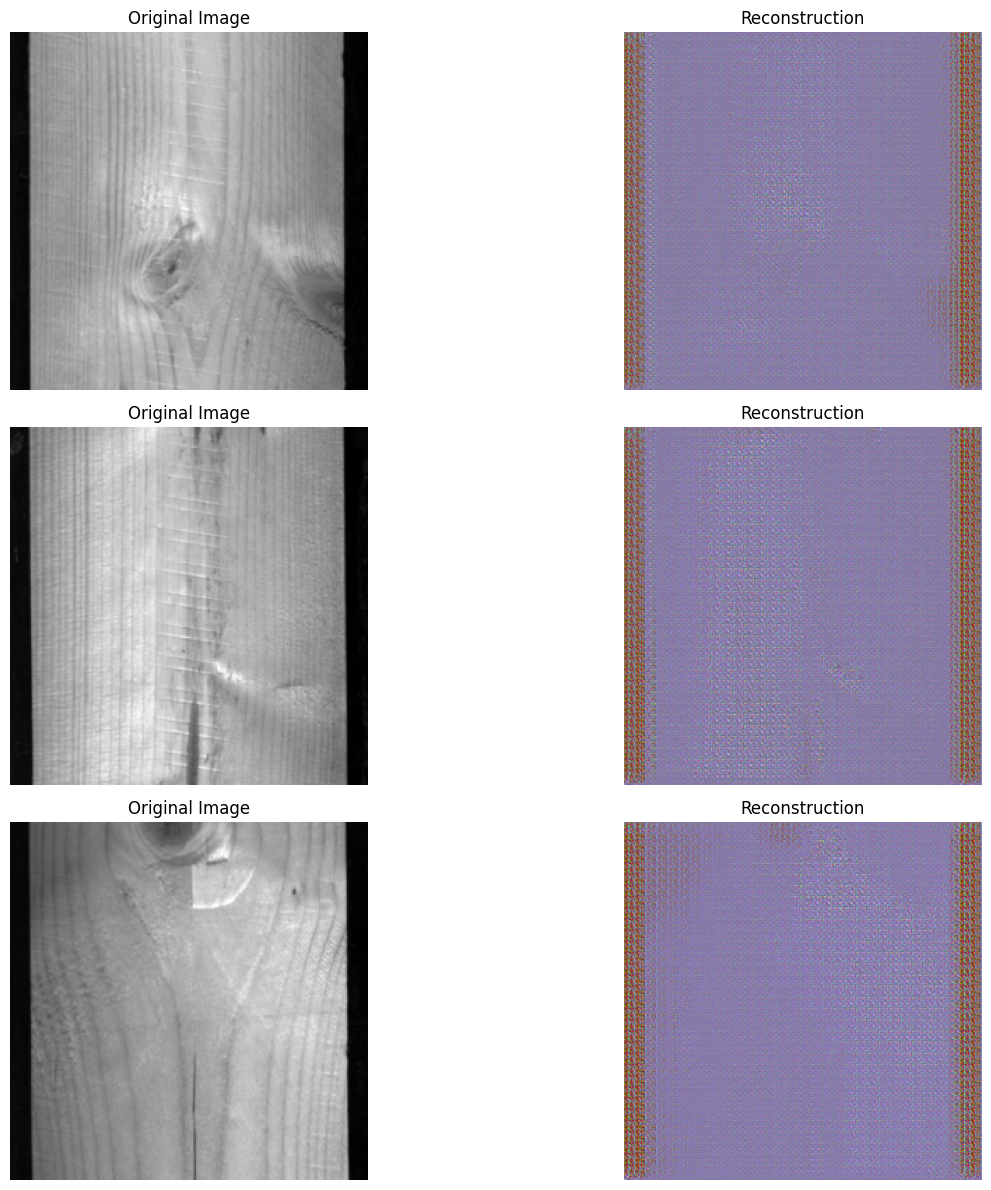

In [11]:
# Visualize ROC curve
plot_roc_curve(evaluation_results["metrics"]["fpr"],
               evaluation_results["metrics"]["tpr"],
               evaluation_results["metrics"]["roc_auc"])

# Visualize score distributions
plot_score_distributions(
    evaluation_results["good"]["scores"],
    evaluation_results["defect"]["scores"],
    threshold=evaluation_results["metrics"]["optimal_threshold"]
)

# Visualize normal samples
print("Normal samples visualization:")
normal_indices = np.random.choice(len(evaluation_results["good"]["scores"]),
                                 size=min(5, len(evaluation_results["good"]["scores"])),
                                 replace=False)
visualize_anomaly_detection(
    evaluation_results["good"]["images"],
    evaluation_results["good"]["maps"],
    evaluation_results["good"]["scores"],
    threshold=evaluation_results["metrics"]["optimal_threshold"],
    indices=normal_indices
)

# Visualize anomaly samples
print("Anomaly samples visualization:")
anomaly_indices = np.random.choice(len(evaluation_results["defect"]["scores"]),
                                  size=min(5, len(evaluation_results["defect"]["scores"])),
                                  replace=False)
visualize_anomaly_detection(
    evaluation_results["defect"]["images"],
    evaluation_results["defect"]["maps"],
    evaluation_results["defect"]["scores"],
    threshold=evaluation_results["metrics"]["optimal_threshold"],
    indices=anomaly_indices
)

# Visualize reconstructions
print("Reconstruction visualization:")
visualize_reconstructions(
    model,
    evaluation_results["good"]["images"],
    num_samples=3
)

print("Defect reconstruction visualization:")
visualize_reconstructions(
    model,
    evaluation_results["defect"]["images"],
    num_samples=3
)

Mean IoU: 0.0000


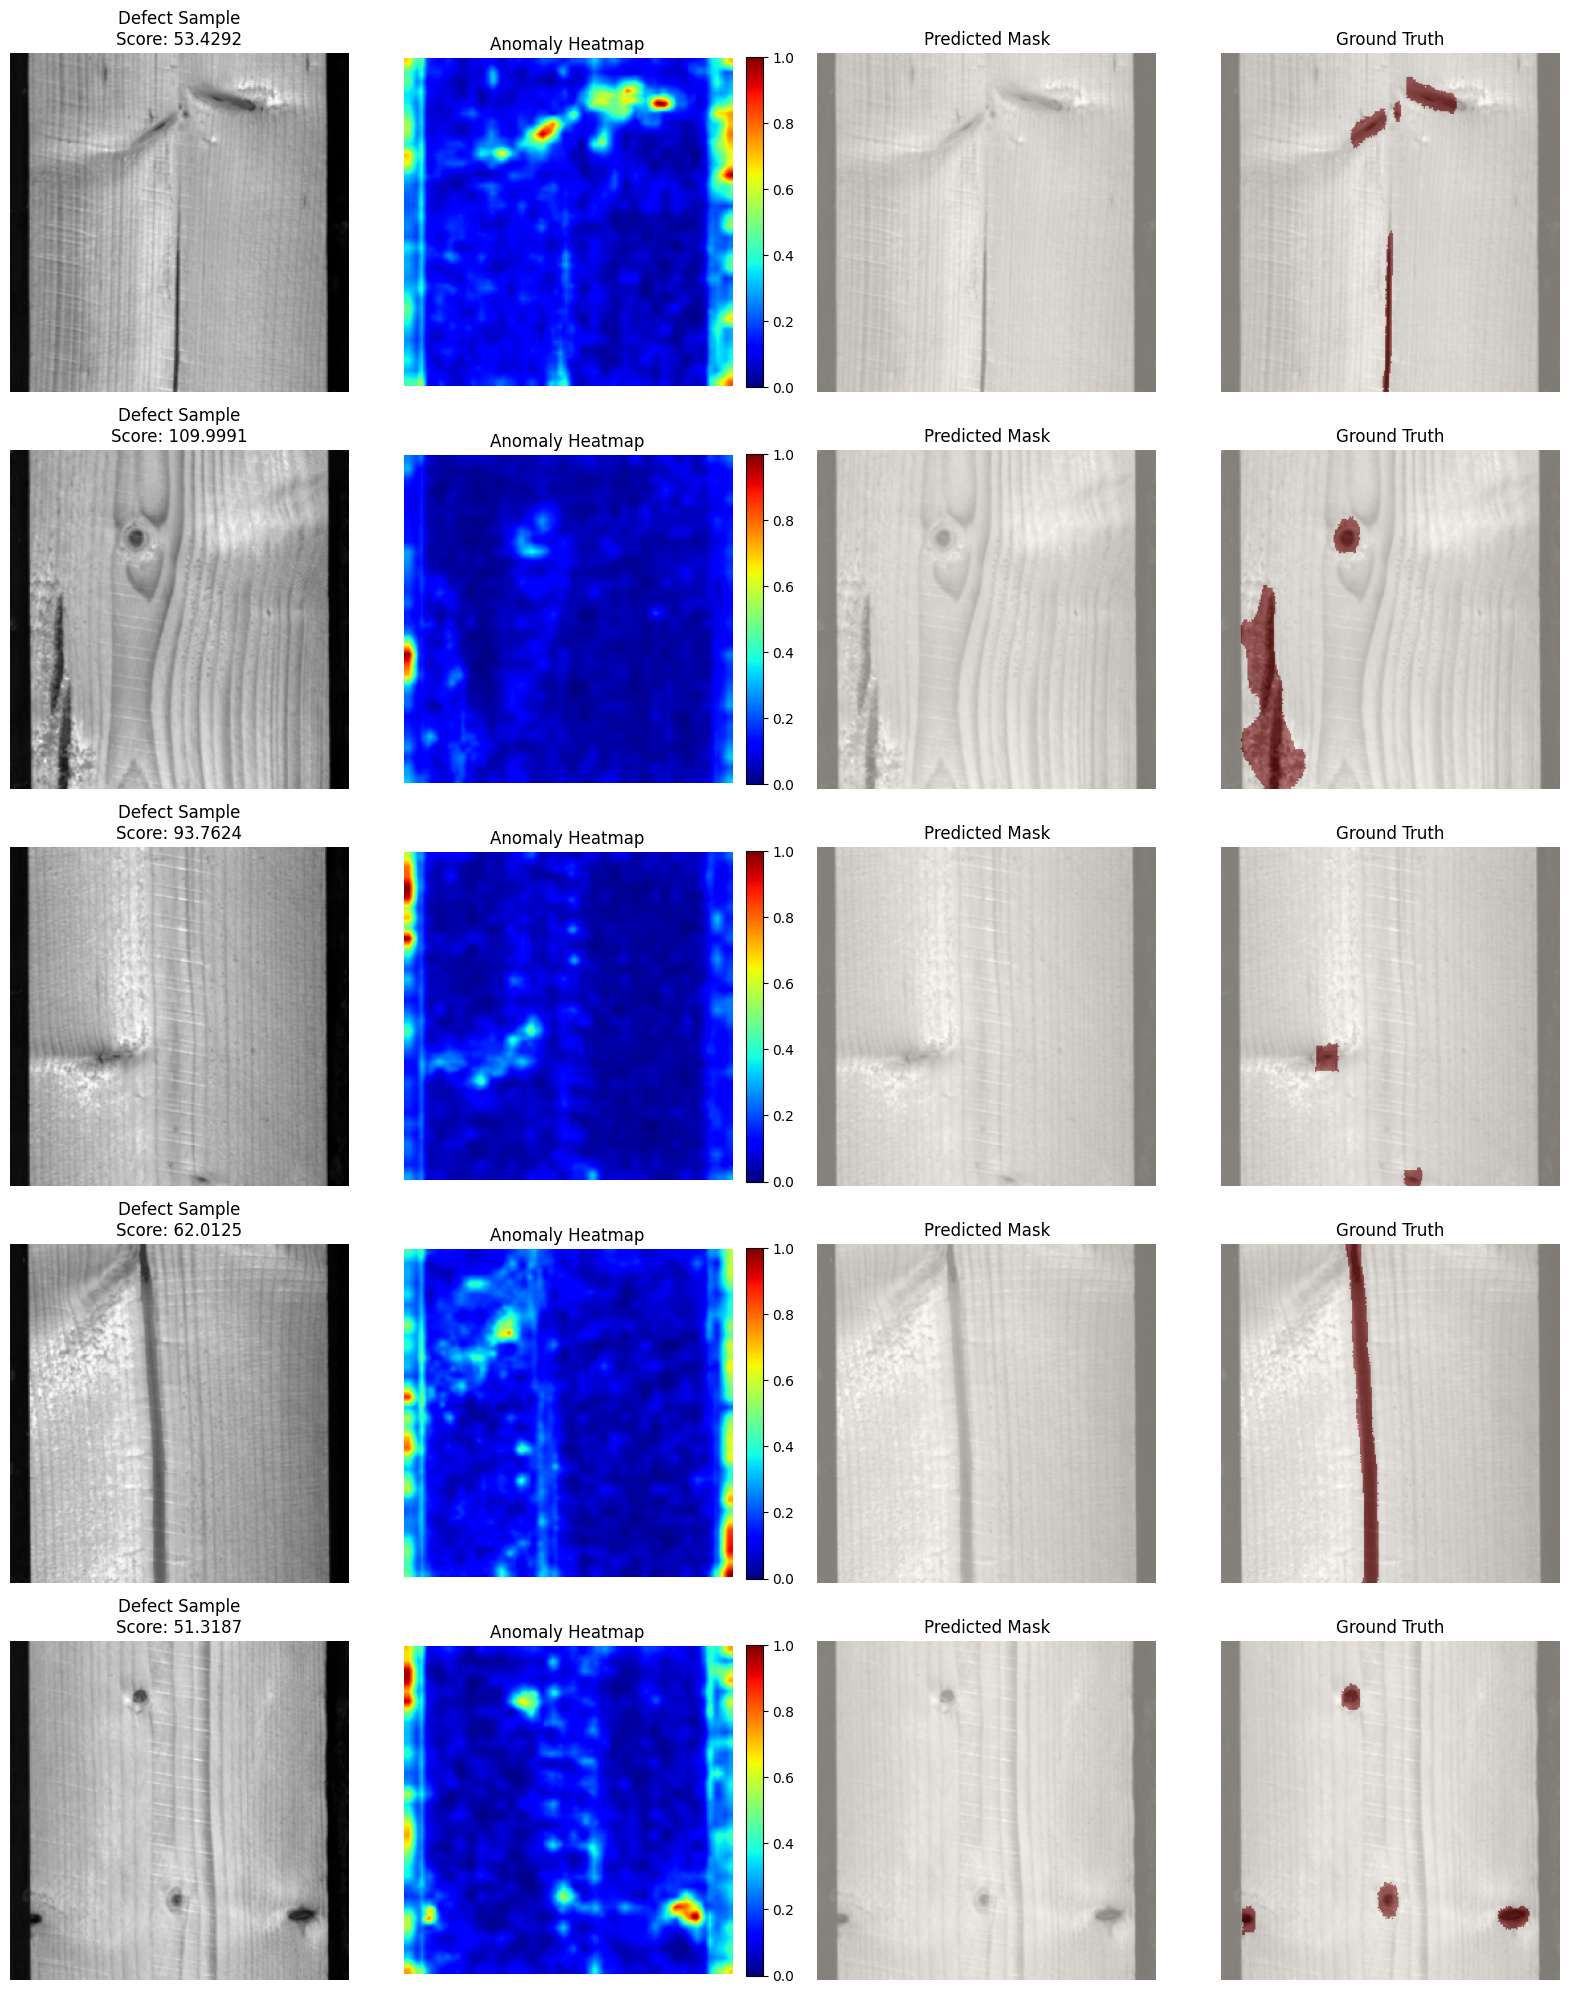

In [12]:
# Load ground truth masks for IoU calculation
def load_masks(mask_paths, size=(256, 256)):
    masks = []
    for path in mask_paths:
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, size)
        mask = (mask > 0).astype(np.float32)  # Convert to binary
        masks.append(mask)
    return masks

# Calculate pixel-level threshold (may need tuning)
# Using a percentile-based approach to set the threshold
pixel_threshold = np.percentile(
    np.concatenate([map_.flatten() for map_ in evaluation_results["defect"]["maps"]]), 80
)

# Load the ground truth masks
ground_truth_masks = load_masks(mask_defect_paths, size=(256, 256))

# Calculate IoU for defect samples
ious = []
for i, score_map in enumerate(evaluation_results["defect"]["maps"]):
    if i < len(ground_truth_masks):
        # Normalize score map
        score_map_norm = (score_map - score_map.min()) / (score_map.max() - score_map.min() + 1e-7)

        # Create binary prediction mask
        pred_mask = (score_map_norm > pixel_threshold).astype(np.uint8)

        # Get ground truth mask
        gt_mask = ground_truth_masks[i].astype(np.uint8)

        # Calculate IoU
        intersection = np.logical_and(pred_mask, gt_mask).sum()
        union = np.logical_or(pred_mask, gt_mask).sum()
        iou = intersection / (union + 1e-10)  # Add small epsilon to avoid division by zero
        ious.append(iou)

mean_iou = np.mean(ious)
print(f"Mean IoU: {mean_iou:.4f}")

# Visualize segmentation results
def visualize_segmentation_results(images, score_maps, scores, ground_truth_masks, threshold, num_samples=5):
    """
    Visualize segmentation results with ground truth comparison.
    """
    # Select random samples from defect images
    indices = np.random.choice(
        min(len(score_maps), len(ground_truth_masks)),
        size=min(num_samples, len(ground_truth_masks)),
        replace=False
    )

    plt.figure(figsize=(16, 4*len(indices)))

    for i, idx in enumerate(indices):
        # Get image and convert from tensor to numpy
        img = images[idx].permute(1, 2, 0).cpu().numpy()
        if np.allclose(img[:,:,0], img[:,:,1]) and np.allclose(img[:,:,1], img[:,:,2]):
            img = img[:,:,0]
        img = (img - img.min()) / (img.max() - img.min())

        # Get anomaly score map
        score_map = score_maps[idx]
        score_map_norm = (score_map - score_map.min()) / (score_map.max() - score_map.min() + 1e-7)

        # Binary prediction mask
        pred_mask = (score_map_norm > threshold).astype(np.float32)

        # Ground truth mask
        gt_mask = ground_truth_masks[idx]

        # Plot results
        plt.subplot(len(indices), 4, 4*i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Defect Sample\nScore: {scores[idx]:.4f}")
        plt.axis('off')

        plt.subplot(len(indices), 4, 4*i + 2)
        plt.imshow(score_map_norm, cmap='jet')
        plt.title('Anomaly Heatmap')
        plt.axis('off')
        plt.colorbar(fraction=0.046, pad=0.04)

        plt.subplot(len(indices), 4, 4*i + 3)
        plt.imshow(img, cmap='gray')
        plt.imshow(pred_mask, cmap='OrRd', alpha=0.5)
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.subplot(len(indices), 4, 4*i + 4)
        plt.imshow(img, cmap='gray')
        plt.imshow(gt_mask, cmap='OrRd', alpha=0.5)
        plt.title('Ground Truth')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize segmentation results
visualize_segmentation_results(
    evaluation_results["defect"]["images"],
    evaluation_results["defect"]["maps"],
    evaluation_results["defect"]["scores"],
    ground_truth_masks,
    threshold=pixel_threshold
)

In [13]:
torch.save(model.state_dict(), '/content/drive/MyDrive/wood_dataset/efficient_ad_final.pth')

In [15]:
import pandas as pd
from datetime import datetime
import base64
from io import BytesIO
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Function to create HTML report for EfficientAD results
def create_efficient_ad_html_report(evaluation_results, mean_iou, pixel_threshold, save_path, history=None):
    """
    Create a comprehensive HTML report with EfficientAD results

    Args:
        evaluation_results: Dictionary with evaluation results
        mean_iou: Mean IoU for segmentation
        pixel_threshold: Threshold used for segmentation
        save_path: Path to save the HTML report
        history: Optional training history dictionary
    """
    # Extract metrics and results
    f1 = evaluation_results["metrics"]["f1"]
    roc_auc = evaluation_results["metrics"]["roc_auc"]
    optimal_threshold = evaluation_results["metrics"]["optimal_threshold"]
    fpr = evaluation_results["metrics"]["fpr"]
    tpr = evaluation_results["metrics"]["tpr"]

    good_scores = evaluation_results["good"]["scores"]
    defect_scores = evaluation_results["defect"]["scores"]

    all_scores = evaluation_results["all"]["scores"]
    true_labels = evaluation_results["metrics"]["y_true"]
    predictions = evaluation_results["metrics"]["y_pred"]

    # Create results dataframe
    results_df = pd.DataFrame({
        'Image_Index': range(len(all_scores)),
        'True_Label': ['Good' if label == 0 else 'Defect' for label in true_labels],
        'Predicted_Label': ['Good' if pred == 0 else 'Defect' for pred in predictions],
        'Anomaly_Score': all_scores,
        'Is_Correct': true_labels == predictions
    })

    # Calculate performance metrics
    conf_matrix = confusion_matrix(true_labels, predictions)
    class_report = classification_report(true_labels, predictions,
                                        target_names=['Good', 'Defect'],
                                        output_dict=True)

    # Generate confusion matrix figure
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Good', 'Defect'],
                yticklabels=['Good', 'Defect'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Save confusion matrix to bytes for embedding in HTML
    conf_matrix_img = BytesIO()
    plt.tight_layout()
    plt.savefig(conf_matrix_img, format='png')
    plt.close()
    conf_matrix_b64 = base64.b64encode(conf_matrix_img.getvalue()).decode('utf-8')

    # Generate ROC curve figure
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    # Save ROC curve to bytes for embedding in HTML
    roc_img = BytesIO()
    plt.tight_layout()
    plt.savefig(roc_img, format='png')
    plt.close()
    roc_b64 = base64.b64encode(roc_img.getvalue()).decode('utf-8')

    # Generate score distribution figure
    plt.figure(figsize=(10, 6))
    sns.histplot(data=results_df, x='Anomaly_Score', hue='True_Label',
                bins=30, kde=True, element='step')
    plt.axvline(x=optimal_threshold, color='red', linestyle='--',
                label=f'Threshold = {optimal_threshold:.4f}')
    plt.legend()
    plt.title('Anomaly Score Distribution')

    # Save distribution figure to bytes for embedding in HTML
    dist_img = BytesIO()
    plt.tight_layout()
    plt.savefig(dist_img, format='png')
    plt.close()
    dist_b64 = base64.b64encode(dist_img.getvalue()).decode('utf-8')

    # Training history plot if available
    if history is not None and 'train_loss' in history:
        plt.figure(figsize=(10, 5))
        plt.plot(history['train_loss'], label='Train Loss')
        if 'val_loss' in history and len(history['val_loss']) > 0:
            plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('EfficientAD Training History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(alpha=0.3)

        # Save history plot to bytes for embedding in HTML
        history_img = BytesIO()
        plt.tight_layout()
        plt.savefig(history_img, format='png')
        plt.close()
        history_b64 = base64.b64encode(history_img.getvalue()).decode('utf-8')
    else:
        history_b64 = None

    # Example visualizations
    example_images = []

    # Generate good example visualizations (2 samples)
    for idx in range(min(2, len(good_scores))):
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Get image
        img = evaluation_results["good"]["images"][idx].permute(1, 2, 0).cpu().numpy()
        if np.allclose(img[:,:,0], img[:,:,1]) and np.allclose(img[:,:,1], img[:,:,2]):
            img = img[:,:,0]
        img = (img - img.min()) / (img.max() - img.min())

        # Get anomaly score map
        score_map = evaluation_results["good"]["maps"][idx]
        score_map_norm = (score_map - score_map.min()) / (score_map.max() - score_map.min() + 1e-7)

        # Plot original image
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title(f'Normal Sample #{idx}')
        axes[0].axis('off')

        # Plot heatmap overlay
        axes[1].imshow(img, cmap='gray')
        heatmap = axes[1].imshow(score_map_norm, cmap='jet', alpha=0.5)
        axes[1].set_title(f'Anomaly Score: {good_scores[idx]:.4f}')
        axes[1].axis('off')
        fig.colorbar(heatmap, ax=axes[1], fraction=0.046, pad=0.04)

        plt.tight_layout()

        img_bytes = BytesIO()
        plt.savefig(img_bytes, format='png')
        plt.close(fig)
        img_b64 = base64.b64encode(img_bytes.getvalue()).decode('utf-8')

        example_images.append({
            'image': img_b64,
            'index': idx,
            'true_class': 'Good',
            'pred_class': 'Good' if predictions[idx] == 0 else 'Defect',
            'is_correct': predictions[idx] == 0,
            'score': good_scores[idx]
        })

    # Generate defect example visualizations (2 samples)
    for i in range(min(2, len(defect_scores))):
        idx = len(good_scores) + i
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Get image
        img = evaluation_results["defect"]["images"][i].permute(1, 2, 0).cpu().numpy()
        if np.allclose(img[:,:,0], img[:,:,1]) and np.allclose(img[:,:,1], img[:,:,2]):
            img = img[:,:,0]
        img = (img - img.min()) / (img.max() - img.min())

        # Get anomaly score map
        score_map = evaluation_results["defect"]["maps"][i]
        score_map_norm = (score_map - score_map.min()) / (score_map.max() - score_map.min() + 1e-7)

        # Plot original image
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title(f'Defect Sample #{i}')
        axes[0].axis('off')

        # Plot heatmap overlay
        axes[1].imshow(img, cmap='gray')
        heatmap = axes[1].imshow(score_map_norm, cmap='jet', alpha=0.5)
        axes[1].set_title(f'Anomaly Score: {defect_scores[i]:.4f}')
        axes[1].axis('off')
        fig.colorbar(heatmap, ax=axes[1], fraction=0.046, pad=0.04)

        plt.tight_layout()

        img_bytes = BytesIO()
        plt.savefig(img_bytes, format='png')
        plt.close(fig)
        img_b64 = base64.b64encode(img_bytes.getvalue()).decode('utf-8')

        example_images.append({
            'image': img_b64,
            'index': idx,
            'true_class': 'Defect',
            'pred_class': 'Good' if predictions[idx] == 0 else 'Defect',
            'is_correct': predictions[idx] == 1,
            'score': defect_scores[i]
        })

    # Generate reconstruction example
    with torch.no_grad():
        # Choose one normal and one anomaly sample
        normal_idx = 0
        anomaly_idx = 0

        # Normal reconstruction
        normal_img = evaluation_results["good"]["images"][normal_idx].unsqueeze(0).to(device)
        normal_output = model(normal_img)
        normal_recon = normal_output['reconstruction'][0].cpu()

        # Anomaly reconstruction
        anomaly_img = evaluation_results["defect"]["images"][anomaly_idx].unsqueeze(0).to(device)
        anomaly_output = model(anomaly_img)
        anomaly_recon = anomaly_output['reconstruction'][0].cpu()

        # Create figure with normal and anomaly reconstructions
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))

        # Normal original
        orig_normal = evaluation_results["good"]["images"][normal_idx].permute(1, 2, 0).cpu().numpy()
        if np.allclose(orig_normal[:,:,0], orig_normal[:,:,1]):
            orig_normal = orig_normal[:,:,0]
        orig_normal = (orig_normal - orig_normal.min()) / (orig_normal.max() - orig_normal.min() + 1e-7)

        # Normal reconstruction
        recon_normal = normal_recon.permute(1, 2, 0).cpu().numpy()
        recon_normal = (recon_normal - recon_normal.min()) / (recon_normal.max() - recon_normal.min() + 1e-7)

        # Anomaly original
        orig_anomaly = evaluation_results["defect"]["images"][anomaly_idx].permute(1, 2, 0).cpu().numpy()
        if np.allclose(orig_anomaly[:,:,0], orig_anomaly[:,:,1]):
            orig_anomaly = orig_anomaly[:,:,0]
        orig_anomaly = (orig_anomaly - orig_anomaly.min()) / (orig_anomaly.max() - orig_anomaly.min() + 1e-7)

        # Anomaly reconstruction
        recon_anomaly = anomaly_recon.permute(1, 2, 0).cpu().numpy()
        recon_anomaly = (recon_anomaly - recon_anomaly.min()) / (recon_anomaly.max() - recon_anomaly.min() + 1e-7)

        # Plot
        axes[0, 0].imshow(orig_normal, cmap='gray')
        axes[0, 0].set_title('Normal Original')
        axes[0, 0].axis('off')

        axes[0, 1].imshow(recon_normal)
        axes[0, 1].set_title('Normal Reconstruction')
        axes[0, 1].axis('off')

        axes[1, 0].imshow(orig_anomaly, cmap='gray')
        axes[1, 0].set_title('Anomaly Original')
        axes[1, 0].axis('off')

        axes[1, 1].imshow(recon_anomaly)
        axes[1, 1].set_title('Anomaly Reconstruction')
        axes[1, 1].axis('off')

        plt.tight_layout()

        recon_img_bytes = BytesIO()
        plt.savefig(recon_img_bytes, format='png')
        plt.close(fig)
        recon_img_b64 = base64.b64encode(recon_img_bytes.getvalue()).decode('utf-8')

    # Create segmentation example visualization
    if len(ground_truth_masks) > 0:
        idx = 0  # First defect example with mask
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        # Get image and convert
        img = evaluation_results["defect"]["images"][idx].permute(1, 2, 0).cpu().numpy()
        if np.allclose(img[:,:,0], img[:,:,1]) and np.allclose(img[:,:,1], img[:,:,2]):
            img = img[:,:,0]
        img = (img - img.min()) / (img.max() - img.min())

        # Get score map
        score_map = evaluation_results["defect"]["maps"][idx]
        score_map_norm = (score_map - score_map.min()) / (score_map.max() - score_map.min() + 1e-7)

        # Binary prediction mask
        pred_mask = (score_map_norm > pixel_threshold).astype(np.float32)

        # Ground truth mask
        gt_mask = ground_truth_masks[idx]

        # Plot
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title(f"Defect Sample\nScore: {defect_scores[idx]:.4f}")
        axes[0].axis('off')

        axes[1].imshow(img, cmap='gray')
        axes[1].imshow(pred_mask, cmap='OrRd', alpha=0.5)
        axes[1].set_title('Predicted Mask')
        axes[1].axis('off')

        axes[2].imshow(img, cmap='gray')
        axes[2].imshow(gt_mask, cmap='OrRd', alpha=0.5)
        axes[2].set_title('Ground Truth')
        axes[2].axis('off')

        plt.tight_layout()

        seg_img_bytes = BytesIO()
        plt.savefig(seg_img_bytes, format='png')
        plt.close(fig)
        seg_img_b64 = base64.b64encode(seg_img_bytes.getvalue()).decode('utf-8')
    else:
        seg_img_b64 = None

    # Create HTML report
    html_content = f'''
    <!DOCTYPE html>
    <html>
    <head>
        <title>Wood Defect Detection - EfficientAD Results</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; }}
            .container {{ max-width: 1200px; margin: 0 auto; }}
            .header {{ text-align: center; margin-bottom: 30px; }}
            .metrics {{ display: flex; justify-content: space-around; margin-bottom: 30px; }}
            .metric-card {{ border: 1px solid #ddd; border-radius: 8px; padding: 15px; width: 200px; text-align: center; }}
            .chart-container {{ margin-bottom: 30px; }}
            .results-table {{ width: 100%; border-collapse: collapse; margin-bottom: 30px; }}
            .results-table th, .results-table td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
            .results-table th {{ background-color: #f2f2f2; }}
            .example-container {{ margin-bottom: 40px; }}
            .example-item {{ margin-bottom: 20px; }}
            .correct {{ color: green; }}
            .incorrect {{ color: red; }}
        </style>
    </head>
    <body>
        <div class="container">
            <div class="header">
                <h1>Wood Defect Detection Report - EfficientAD</h1>
                <p>Generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
            </div>

            <h2>Performance Summary</h2>
            <div class="metrics">
                <div class="metric-card">
                    <h3>Accuracy</h3>
                    <p>{(true_labels == predictions).mean():.4f}</p>
                </div>
                <div class="metric-card">
                    <h3>F1 Score</h3>
                    <p>{f1:.4f}</p>
                </div>
                <div class="metric-card">
                    <h3>ROC AUC</h3>
                    <p>{roc_auc:.4f}</p>
                </div>
                <div class="metric-card">
                    <h3>Mean IoU</h3>
                    <p>{mean_iou:.4f}</p>
                </div>
            </div>
    '''

    # Add training history if available
    if history_b64:
        html_content += f'''
            <div class="chart-container">
                <h2>Training History</h2>
                <img src="data:image/png;base64,{history_b64}" alt="Training History" style="max-width:100%;">
            </div>
        '''

    html_content += f'''
            <div class="chart-container">
                <h2>Confusion Matrix</h2>
                <img src="data:image/png;base64,{conf_matrix_b64}" alt="Confusion Matrix" style="max-width:100%;">
            </div>

            <div class="chart-container">
                <h2>ROC Curve</h2>
                <img src="data:image/png;base64,{roc_b64}" alt="ROC Curve" style="max-width:100%;">
            </div>

            <div class="chart-container">
                <h2>Anomaly Score Distribution</h2>
                <img src="data:image/png;base64,{dist_b64}" alt="Score Distribution" style="max-width:100%;">
            </div>

            <h2>Classification Results</h2>
            <table class="results-table">
                <tr>
                    <th>Class</th>
                    <th>Precision</th>
                    <th>Recall</th>
                    <th>F1-Score</th>
                    <th>Support</th>
                </tr>
                <tr>
                    <td>Good</td>
                    <td>{class_report['Good']['precision']:.4f}</td>
                    <td>{class_report['Good']['recall']:.4f}</td>
                    <td>{class_report['Good']['f1-score']:.4f}</td>
                    <td>{class_report['Good']['support']}</td>
                </tr>
                <tr>
                    <td>Defect</td>
                    <td>{class_report['Defect']['precision']:.4f}</td>
                    <td>{class_report['Defect']['recall']:.4f}</td>
                    <td>{class_report['Defect']['f1-score']:.4f}</td>
                    <td>{class_report['Defect']['support']}</td>
                </tr>
            </table>

            <h2>Model Details</h2>
            <table class="results-table">
                <tr>
                    <th>Parameter</th>
                    <th>Value</th>
                </tr>
                <tr>
                            <h2>Model Details</h2>
            <table class="results-table">
                <tr>
                    <th>Parameter</th>
                    <th>Value</th>
                </tr>
                <tr>
                    <td>Architecture</td>
                    <td>EfficientAD (Teacher-Student)</td>
                </tr>
                <tr>
                    <td>Backbone</td>
                    <td>EfficientNet-B0</td>
                </tr>
                <tr>
                    <td>Early Layer</td>
                    <td>{model.early_layer_idx}</td>
                </tr>
                <tr>
                    <td>Mid Layer</td>
                    <td>{model.mid_layer_idx}</td>
                </tr>
                <tr>
                    <td>Optimal Threshold</td>
                    <td>{optimal_threshold:.4f}</td>
                </tr>
            </table>

            <h2>Example Visualizations</h2>
            <div class="example-container">
    '''

    # Add example visualizations to HTML
    for example in example_images:
        correct_class = 'correct' if example['is_correct'] else 'incorrect'
        html_content += f'''
                <div class="example-item">
                    <h3>Image #{example['index']} -
                        <span>True: {example['true_class']}, </span>
                        <span class="{correct_class}">Predicted: {example['pred_class']}</span>
                        <span>(Score: {example['score']:.4f})</span>
                    </h3>
                    <img src="data:image/png;base64,{example['image']}" alt="Example" style="max-width:100%;">
                </div>
        '''

    # Add reconstruction visualization
    html_content += f'''
            <h2>Reconstruction Examples</h2>
            <div class="example-item">
                <p>Comparison of original images and their reconstructions for normal and anomaly samples</p>
                <img src="data:image/png;base64,{recon_img_b64}" alt="Reconstructions" style="max-width:100%;">
            </div>
    '''

    # Add segmentation example if available
    if seg_img_b64:
        html_content += f'''
            <h2>Segmentation Example</h2>
            <div class="example-item">
                <p>Example showing original image, predicted segmentation mask, and ground truth mask. Mean IoU: {mean_iou:.4f}</p>
                <img src="data:image/png;base64,{seg_img_b64}" alt="Segmentation Example" style="max-width:100%;">
            </div>
        '''

    html_content += '''
            </div>
        </div>
    </body>
    </html>
    '''

    # Save the HTML report
    with open(save_path, 'w') as f:
        f.write(html_content)

    print(f"EfficientAD classification report saved to: {save_path}")

    # Output a summary of classification results
    print("\nClassification Summary:")
    print(f"Total Images: {len(all_scores)}")
    print(f"Good Images: {len(good_scores)}, Defect Images: {len(defect_scores)}")
    print(f"Correctly Classified: {(true_labels == predictions).sum()} / {len(all_scores)}")
    print(f"Accuracy: {(true_labels == predictions).mean():.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")

# Create and save the HTML report
report_path = os.path.join(DATASET_DIR, 'efficient_ad_report.html')
create_efficient_ad_html_report(
    evaluation_results,
    mean_iou,
    pixel_threshold,
    report_path,
    history=history
)

Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
Resizing reconstruction from torch.Size([512, 512]) to torch.Size([256, 256])
EfficientAD classification report saved to: /content/drive/MyDrive/wood_dataset/wood/efficient_ad_report.html

Classification Summary:
Total Images: 141
Good Images: 70, Defect Images: 71
Correctly Classified: 82 / 141
Accuracy: 0.5816
F1 Score: 0.6811
ROC AUC: 0.5594
Mean IoU: 0.0000
